In [1]:
import os
import pandas as pd

df = pd.read_csv("./results_merged/extracted_answers_passk.csv")

def parse_filename(name: str):
    base = os.path.basename(name)
    # strip extension
    if base.endswith(".json"):
        base = base[:-5]
    # strip leading prefix
    if base.startswith("eval_"):
        base = base[len("eval_"):]
    base = base.split("stamp-")[0]
    parts = base.split("_")



    # now we expect:
    # [model, budget, window, "complex", mode, rotation, topk, (optional) epochs]

    result = {
        "model": None,
        "budget": None,
        "window": None,
        "mode": None,
        "rotation": None,
        "topk": None,
        "epochs": 1,  # default
    }

    # if len(parts) >= 1:
    #     result["model"] = parts[0]
    # if len(parts) >= 2:
    #     try:
    #         result["budget"] = int(parts[1])
    #     except ValueError:
    #         pass
    # if len(parts) >= 3:
    #     try:
    #         result["window"] = int(parts[2])
    #     except ValueError:
    #         pass
    # if len(parts) >= 5:
    #     result["mode"] = parts[4]
    # if len(parts) >= 6:
    #     try:
    #         result["rotation"] = int(parts[5])
    #     except ValueError:
    #         pass
    # if len(parts) >= 7:
    #     try:
    #         result["topk"] = int(parts[6])
    #     except ValueError:
    #         pass
    # if len(parts) >= 8:
    #     # optional epochs after topk
    #     try:
    #         result["epochs"] = int(parts[7])
    #     except ValueError:
    #         pass
    try:
        model, budget, window, _, mode, rotation, topk, *epochs = parts
    except:
        print(f"Failed to parse: {name}")
        print(parts)
        return result
    # print(parts)

    try:

        result["model"] = model
        result["budget"] = int(budget)
        result["window"] = int(window)
        result["mode"] = mode
        result["rotation"] = int(rotation)
        result["topk"] = int(topk)
        if epochs and len(epochs[0]):
            result["epochs"] = int(epochs[0])
        else:
            result["epochs"] = 1
    except Exception as e:
        # print(parts)
        pass
        
    return result

parsed = df["filename"].apply(parse_filename).apply(pd.Series)
df = pd.concat([df, parsed], axis=1)
print('nan_count', df[df.isna().any(axis=1)].shape[0])
df.dropna(inplace=True)
df.drop(columns=["total_tryouts", "k_used"], inplace=True)
df.rename(columns={"pass_at_k": "pass@1"}, inplace=True)
df.to_csv("extracted_answers_passk_parsed.csv", index=False)
df.reset_index(inplace=True)
df

nan_count 0


,index,filename,pass@1,correct_count,boxed_count,model,budget,window,mode,rotation,topk,epochs
0,0,eval_DS7B_256_128_complex_takeaways_8192_1_sta...,0.9375,15,14,DS7B,256,128,takeaways,8192,1,1
1,1,eval_DS7B_512_256_complex_takeaways_2048_3_sta...,0.8750,14,13,DS7B,512,256,takeaways,2048,3,1
2,2,eval_DS7B_256_128_complex_notepad_256_1_stamp-...,0.8125,13,14,DS7B,256,128,notepad,256,1,1
3,3,eval_DS7B_256_128_complex_notepad_256_2_stamp-...,0.8125,13,14,DS7B,256,128,notepad,256,2,1
4,4,eval_DS7B_256_128_complex_takeaways_256_2_stam...,0.8125,13,14,DS7B,256,128,takeaways,256,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
366,366,eval_LEAD7B_8192_384_complex_notepad_8192_5_3_...,0.0000,0,14,LEAD7B,8192,384,notepad,8192,5,3
367,367,eval_LEAD7B_8192_384_complex_takeaways_0_2_3_s...,0.0000,0,15,LEAD7B,8192,384,takeaways,0,2,3
368,368,eval_LEAD7B_8192_512_complex_notepad_0_13_5_st...,0.0000,0,0,LEAD7B,8192,512,notepad,0,13,5
369,369,eval_LEAD7B_8192_64_complex_notepad_0_1_3_stam...,0.0000,0,16,LEAD7B,8192,64,notepad,0,1,3


/tmp/ipykernel_472161/3210511054.py:37: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=max_df, x='model', y='pass@1', hue='mode',


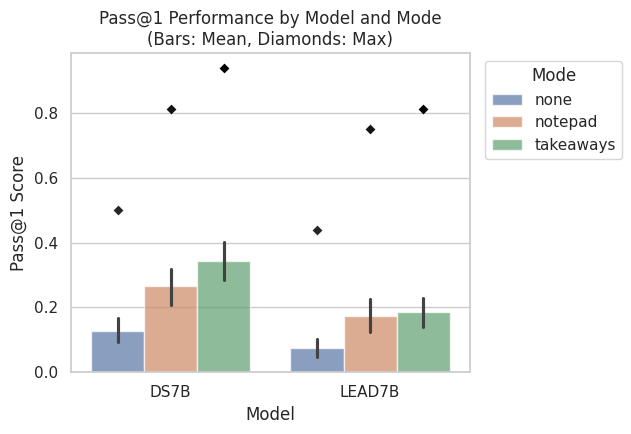

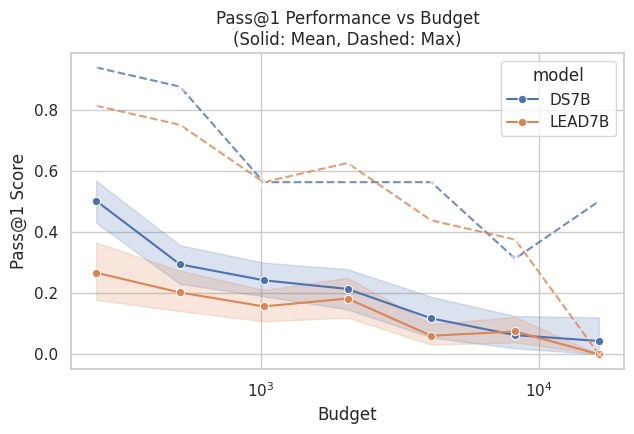

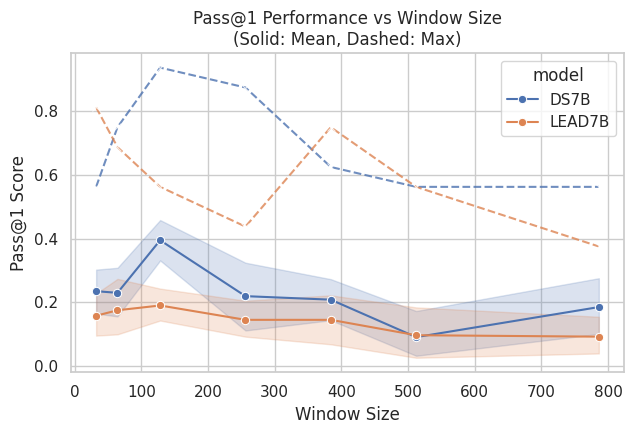

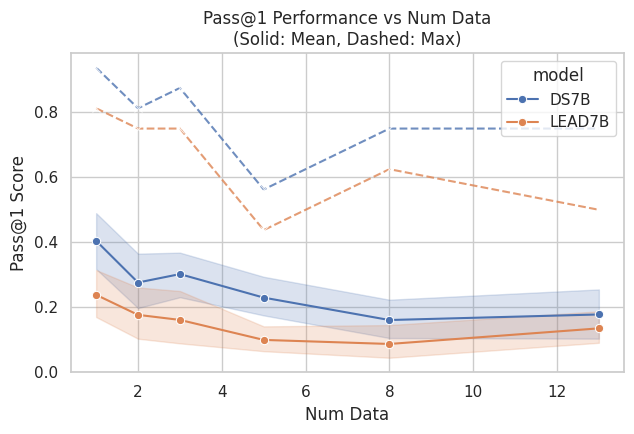

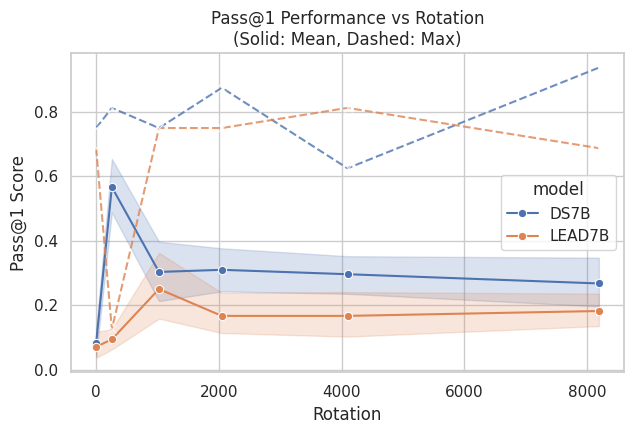

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Setup
os.makedirs('plots', exist_ok=True)
sns.set_theme(style="whitegrid")
figsize = (6.5, 4.5)

# 2. Load and Preprocess
df = pd.read_csv('extracted_answers_passk_parsed.csv')
df_plot = df.copy()
df_plot['mode'] = df_plot['mode'].fillna('Unknown')

# Define hue orders to ensure colors/alignment match between overlays
model_order = sorted(df_plot['model'].unique())
mode_order = sorted(df_plot['mode'].unique())

# -------------------------------------------------------
# Plot 1: Performance by Model and Mode (Bar + Max Marker)
# -------------------------------------------------------
plt.figure(figsize=figsize)

# A. Base Bar Plot (Mean)
# We set alpha to make it slightly transparent so the max markers pop
sns.barplot(data=df_plot, x='model', y='pass@1', hue='mode', 
            hue_order=mode_order, alpha=0.7, errorbar=('ci', 95))

# B. Overlay Max Values
# Calculate max per group to plot distinct markers
max_df = df_plot.groupby(['model', 'mode'])['pass@1'].max().reset_index()

# Use stripplot to align markers with the grouped bars (dodge=True)
# We use black diamonds ('D') to represent the Max
sns.stripplot(data=max_df, x='model', y='pass@1', hue='mode', 
              hue_order=mode_order, dodge=True, jitter=False, 
              marker='D', size=5, color='black', legend=False)

plt.title('Pass@1 Performance by Model and Mode\n(Bars: Mean, Diamonds: Max)')
plt.xlabel('Model')
plt.ylabel('Pass@1 Score')
plt.legend(title='Mode', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.savefig('plots/performance_model_mode_max.svg')
plt.show()

# -------------------------------------------------------
# Helper Function for Line Plots (Mean + Max)
# -------------------------------------------------------
def plot_line_with_max(x_col, xlabel, filename, xscale=None):
    plt.figure(figsize=figsize)
    
    # 1. Plot Mean (Solid Line)
    # This draws the standard trend line with confidence intervals
    sns.lineplot(data=df_plot, x=x_col, y='pass@1', hue='model', 
                 hue_order=model_order, marker='o', linestyle='-', 
                 errorbar=('ci', 95))
                 
    # 2. Plot Max (Dashed Line)
    # We disable the legend here to avoid duplicates.
    # estimator='max' calculates the max, errorbar=None removes the band.
    sns.lineplot(data=df_plot, x=x_col, y='pass@1', hue='model', 
                 hue_order=model_order, estimator='max', errorbar=None, 
                 linestyle='--', marker='x', legend=False, alpha=0.8)

    plt.title(f'Pass@1 Performance vs {xlabel}\n(Solid: Mean, Dashed: Max)')
    plt.xlabel(xlabel)
    plt.ylabel('Pass@1 Score')
    if xscale:
        plt.xscale(xscale)
        
    plt.tight_layout()
    plt.savefig(f'plots/{filename}')
    plt.show()


# -------------------------------------------------------
# Plot 2: Performance vs Budget
# -------------------------------------------------------
plot_line_with_max('budget', 'Budget', 'performance_budget_line_max.svg', xscale='log')

# -------------------------------------------------------
# Plot 3: Performance vs Window Size
# -------------------------------------------------------
plot_line_with_max('window', 'Window Size', 'performance_window_line_max.svg')

# -------------------------------------------------------
# Plot 4: Performance vs Num Data
# -------------------------------------------------------
plot_line_with_max('topk', 'Num Data', 'performance_topk_line_max.svg')


# -------------------------------------------------------
# Plot 5: Performance vs Rotation
# -------------------------------------------------------
# Note: Using linear scale because rotation usually contains 0
plot_line_with_max('rotation', 'Rotation', 'performance_rotation_line_max.svg')

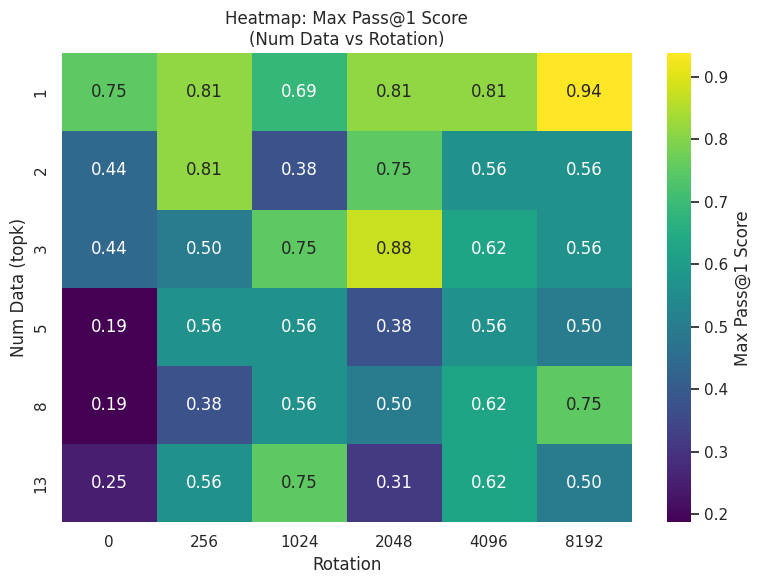

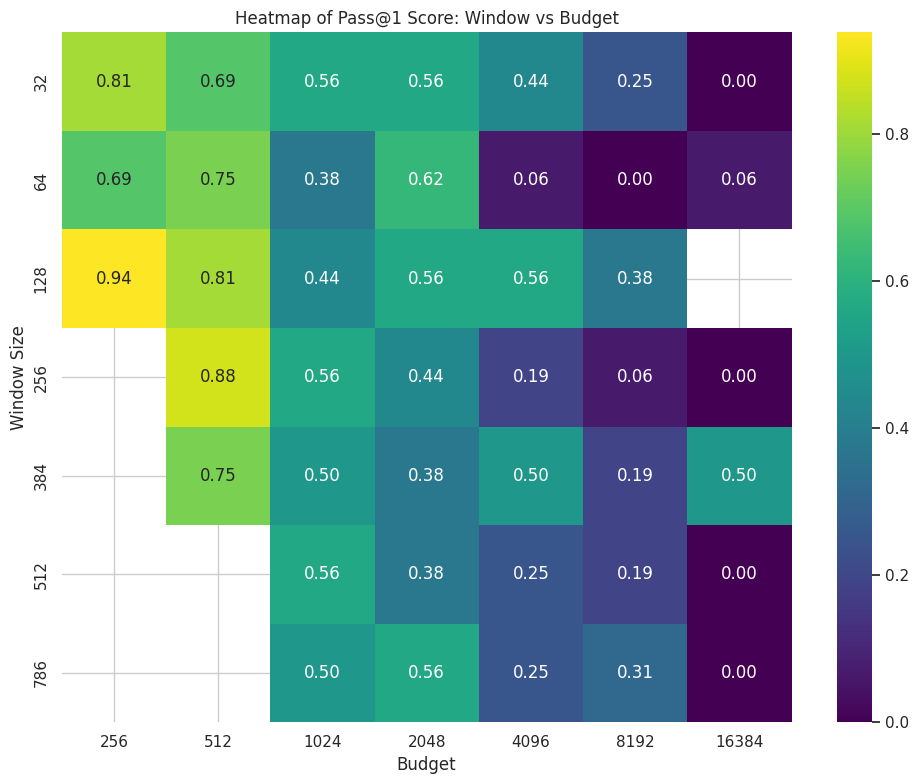

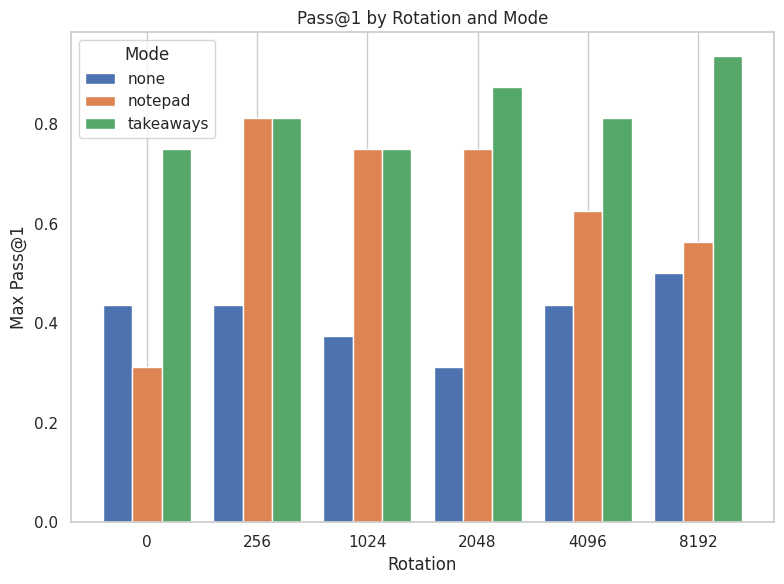

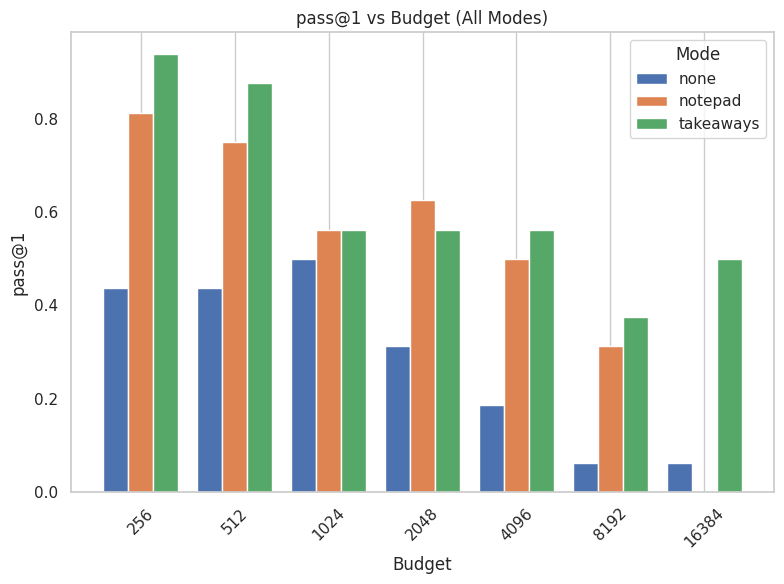

In [14]:

# -------------------------------------------------------
# Plot 6: Heatmap (Num Data vs Rotation)
# -------------------------------------------------------
plt.figure(figsize=figsize)

# 1. Prepare Data
# Group by the two variables and calculate the mean Pass@1
heatmap_data = df_plot.groupby(['topk', 'rotation'])['pass@1'].max().reset_index()

# Pivot to create a matrix format: Rows=Num Data (topk), Cols=Rotation
heatmap_matrix = heatmap_data.pivot(index='topk', columns='rotation', values='pass@1')

# Sort index/columns to ensure axes are ordered logically
heatmap_matrix = heatmap_matrix.sort_index(ascending=True) # Sort Y axis (Num Data)
heatmap_matrix = heatmap_matrix.sort_index(axis=1, ascending=True) # Sort X axis (Rotation)

# 2. Plot Heatmap
# annot=True adds the numbers to the squares
# fmt='.2f' formats them to 2 decimal places
# cmap='viridis' is a standard color map (Purple=Low, Yellow=High)
sns.heatmap(heatmap_matrix, annot=True, fmt='.2f', cmap='viridis', 
            cbar_kws={'label': 'Max Pass@1 Score'})

plt.title('Heatmap: Max Pass@1 Score\n(Num Data vs Rotation)')
plt.ylabel('Num Data (topk)')
plt.xlabel('Rotation')
plt.tight_layout()
plt.savefig('plots/heatmap_topk_rotation.svg')
plt.show()

# -------------------------------------------------------
# Plot 5: Heatmap (Kept original size)
# -------------------------------------------------------
pivot_table = df_plot.pivot_table(values='pass@1', index='window', columns='budget', aggfunc='max')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".2f")
plt.title('Heatmap of Pass@1 Score: Window vs Budget')
plt.xlabel('Budget')
plt.ylabel('Window Size')
plt.tight_layout()
plt.savefig('plots/heatmap_budget_window.svg', )


# -------------------------------------------------------
# Plot 6: Pass@k by Rotation and Mode (Bar Plot)
# -------------------------------------------------------
grouped = (
    df_plot.groupby(["rotation", "mode"], as_index=False)
      .agg({"pass@1": "max"})
      .sort_values(["rotation", "mode"])
)

rotations = sorted(grouped["rotation"].unique().astype(int))
modes = sorted(grouped["mode"].unique())
x = np.arange(len(rotations))
bar_width = 0.8 / max(1, len(modes))

plt.figure(figsize=figsize)
for i, mode in enumerate(modes):
    sub = grouped[grouped["mode"] == mode]
    sub = sub.set_index("rotation").reindex(rotations)
    offsets = x + i * bar_width - (len(modes) - 1) * bar_width / 2
    plt.bar(offsets, sub["pass@1"], width=bar_width, label=mode)

plt.xticks(x, rotations)
plt.xlabel("Rotation")
plt.ylabel("Max Pass@1")
plt.title("Pass@1 by Rotation and Mode")
plt.legend(title='Mode')
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("plots/pass1_by_rotation_mode.svg", )


# -------------------------------------------------------
# Plot 7: Pass@1 vs Budget (Bar Plot)
# -------------------------------------------------------
metric = "pass@1"
grouped = df_plot.groupby(["budget", "mode"], as_index=False)[metric].max()
budgets = np.sort(grouped["budget"].unique())
modes = sorted(grouped["mode"].dropna().unique())

x = np.arange(len(budgets))
n_modes = len(modes)
bar_width = 0.8 / max(1, n_modes)

plt.figure(figsize=figsize)
for i, mode in enumerate(modes):
    sub = grouped[grouped["mode"] == mode].set_index("budget").reindex(budgets)
    vals = sub[metric].values
    offsets = x + (i - (n_modes - 1) / 2) * bar_width
    plt.bar(offsets, vals, width=bar_width, label=mode)

plt.xticks(x, budgets, rotation=45)
plt.xlabel("Budget")
plt.ylabel(metric)
plt.title(f"{metric} vs Budget (All Modes)")
plt.grid(axis="y")
plt.legend(title="Mode")
plt.tight_layout()
plt.savefig("plots/pass1_vs_budget_bar.svg", )


New plots generated successfully.


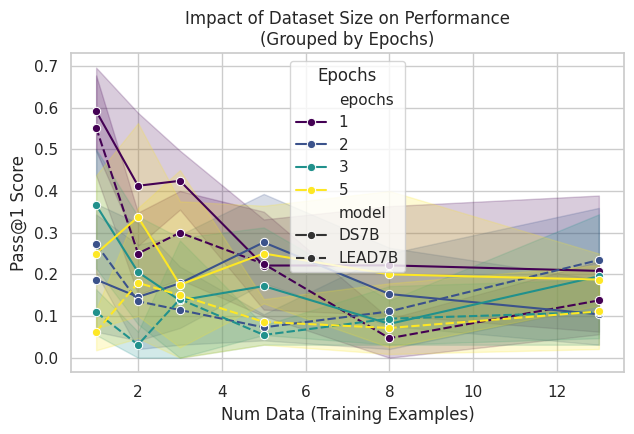

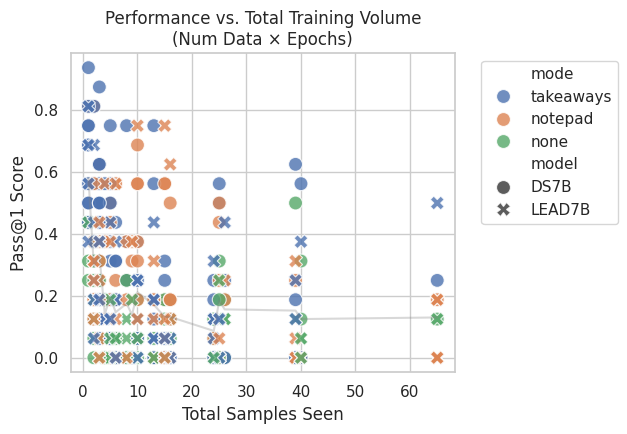

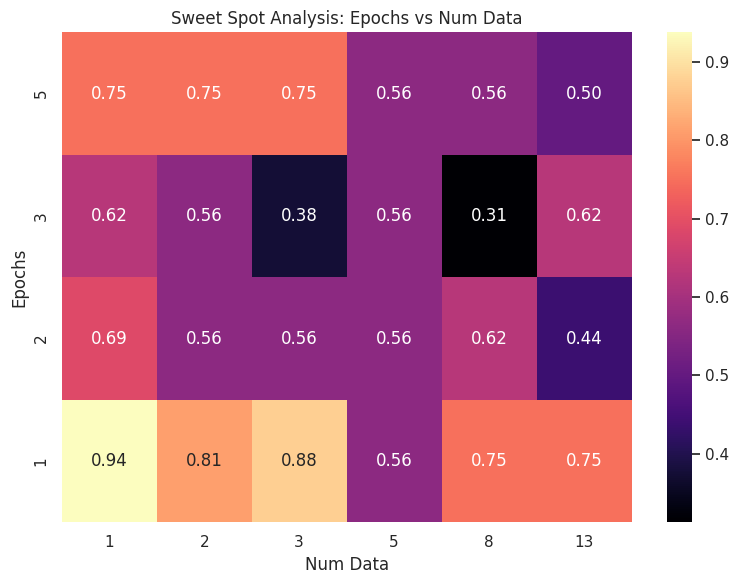

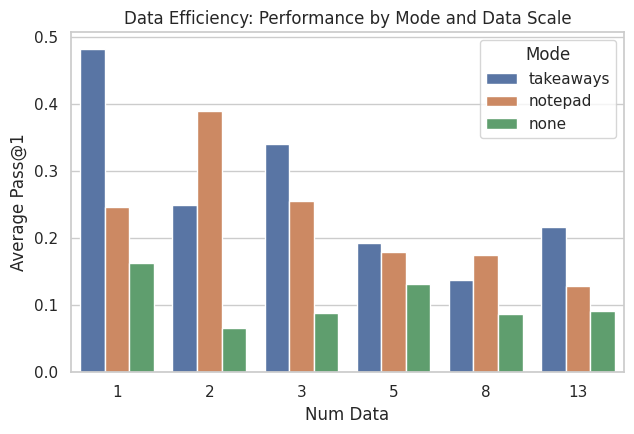

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Setup
os.makedirs('plots', exist_ok=True)
sns.set_theme(style="whitegrid")
figsize = (6.5, 4.5)

# 2. Load and Preprocess
df = pd.read_csv('extracted_answers_passk_parsed.csv')
df_plot = df.copy()

# Rename 'topk' to 'Num Data' as requested
df_plot = df_plot.rename(columns={'topk': 'Num Data'})

# Fill missing modes
df_plot['mode'] = df_plot['mode'].fillna('Unknown')

# Create a 'Total Samples Seen' metric for analysis
# This represents the total training volume (unique data * repetitions)
df_plot['Total Samples'] = df_plot['Num Data'] * df_plot['epochs']

# Convert epochs to string or category for better discrete coloring in line plots
df_plot['Epochs (Cat)'] = df_plot['epochs'].astype(str)

# -------------------------------------------------------
# Plot 8: Num Data vs Pass@1 (Hue: Epochs)
# -------------------------------------------------------
# Purpose: Does adding more unique data help? Does the effect change 
# if we train for more epochs?
plt.figure(figsize=figsize)
sns.lineplot(
    data=df_plot, 
    x='Num Data', 
    y='pass@1', 
    hue='epochs', 
    palette='viridis', 
    marker='o',
    style='model' # Different line styles for models to differentiate
)
plt.title('Impact of Dataset Size on Performance\n(Grouped by Epochs)')
plt.xlabel('Num Data (Training Examples)')
plt.ylabel('Pass@1 Score')
plt.legend(title='Epochs')
plt.tight_layout()
plt.savefig('plots/performance_numdata_by_epoch.svg')

# -------------------------------------------------------
# Plot 9: Total Samples Seen vs Pass@1
# -------------------------------------------------------
# Purpose: Is performance purely a function of total volume?
# (e.g., is 4 data points * 2 epochs == 8 data points * 1 epoch?)
plt.figure(figsize=figsize)
sns.scatterplot(
    data=df_plot, 
    x='Total Samples', 
    y='pass@1', 
    hue='mode', 
    style='model',
    s=100, # Marker size
    alpha=0.8
)
# Add a trendline (optional, using regplot logic or just simple lineplot)
sns.lineplot(
    data=df_plot,
    x='Total Samples',
    y='pass@1',
    color='gray',
    alpha=0.3,
    errorbar=None
)

plt.title('Performance vs. Total Training Volume\n(Num Data × Epochs)')
plt.xlabel('Total Samples Seen')
plt.ylabel('Pass@1 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend out if crowded
plt.tight_layout()
plt.savefig('plots/performance_total_samples.svg')

# -------------------------------------------------------
# Plot 10: Heatmap: Num Data vs Epochs
# -------------------------------------------------------
# Purpose: Find the "Sweet Spot". Where is the highest accuracy?
# Aggregating by mean in case there are multiple runs per cell.
pivot_train = df_plot.pivot_table(
    values='pass@1', 
    index='epochs', 
    columns='Num Data', 
    aggfunc='max'
)

plt.figure(figsize=(8, 6)) # Slightly wider for heatmap
sns.heatmap(pivot_train, annot=True, cmap='magma', fmt=".2f")
plt.title('Sweet Spot Analysis: Epochs vs Num Data (Max Pass@1)')
plt.xlabel('Num Data')
plt.ylabel('Epochs')
plt.gca().invert_yaxis() # Put lower epochs at bottom (standard graph convention)
plt.tight_layout()
plt.savefig('plots/heatmap_epochs_numdata.svg')

# -------------------------------------------------------
# Plot 11: Data Efficiency by Mode (Bar Plot)
# -------------------------------------------------------
# Purpose: Comparing how different modes scale with data.
# Do some modes need less data ("Num Data") to achieve high scores?

plt.figure(figsize=figsize)
sns.barplot(
    data=df_plot, 
    x='Num Data', 
    y='pass@1', 
    hue='mode',
    errorbar=None # Clean look, remove if you want error bars
)
plt.title('Data Efficiency: Performance by Mode and Data Scale')
plt.xlabel('Num Data')
plt.ylabel('Average Pass@1')
plt.legend(title='Mode')
plt.tight_layout()
plt.savefig('plots/performance_mode_efficiency.svg')

print("New plots generated successfully.")

/tmp/ipykernel_370673/694313256.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Additional meaningful plots generated.


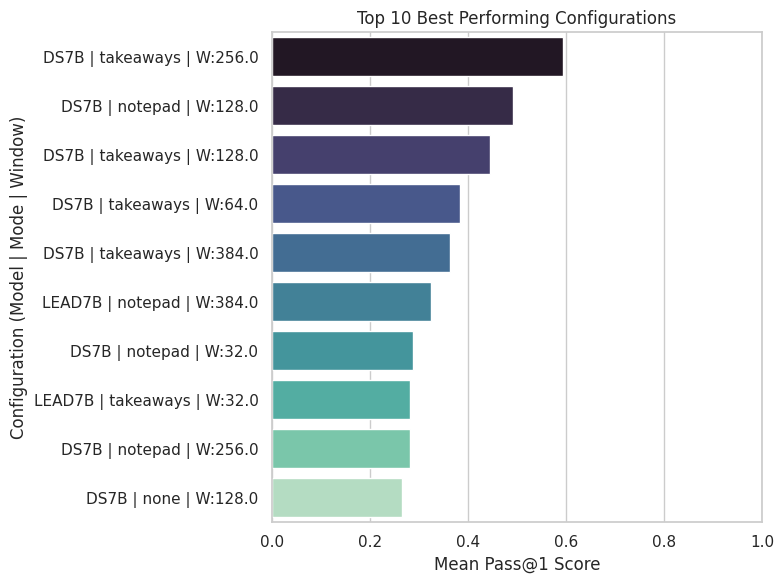

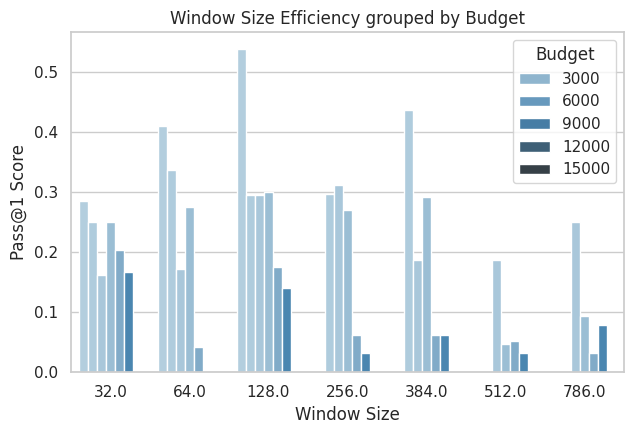

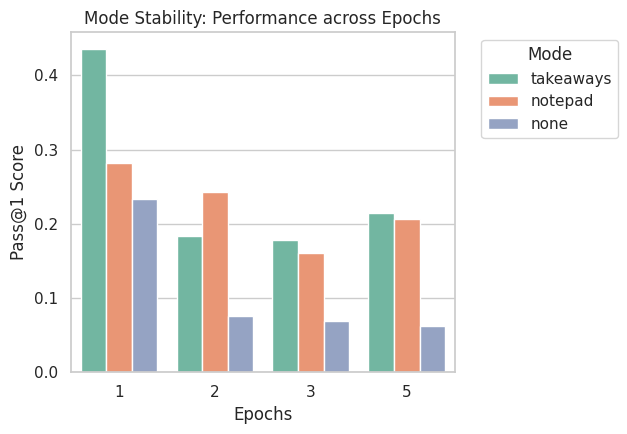

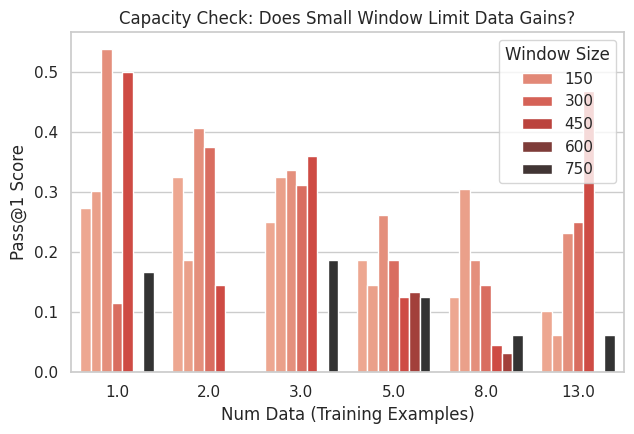

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setup (assuming previous df_plot exists, but reloading for safety)
# Ensure 'topk' is renamed if running this block independently
if 'Num Data' not in df_plot.columns and 'topk' in df_plot.columns:
    df_plot = df_plot.rename(columns={'topk': 'Num Data'})

# -------------------------------------------------------
# Plot 12: The "Leaderboard" (Top 10 Configurations)
# -------------------------------------------------------
# We create a composite name to identify the run
df_plot['config_name'] = (
    df_plot['model'] + " | " + 
    df_plot['mode'] + " | W:" + 
    df_plot['window'].astype(str)
)

# Sort by pass@1 and take the top 10 unique configurations
top_configs = (
    df_plot.groupby('config_name')['pass@1']
    .max()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_configs, 
    y='config_name', 
    x='pass@1', 
    palette='mako'
)
plt.title('Top 10 Best Performing Configurations')
plt.xlabel('Mean Pass@1 Score')
plt.ylabel('Configuration (Model | Mode | Window)')
plt.xlim(0, 1.0) # assuming score is 0-1
plt.tight_layout()
plt.savefig('plots/top_10_leaderboard.svg')


# -------------------------------------------------------
# Plot 13: Window Efficiency (Window vs Budget)
# -------------------------------------------------------
# Does a larger window require a larger budget to be effective?
plt.figure(figsize=figsize)
sns.barplot(
    data=df_plot, 
    x='window', 
    y='pass@1', 
    hue='budget', 
    palette='Blues_d',
    errorbar=None
)
plt.title('Window Size Efficiency grouped by Budget')
plt.xlabel('Window Size')
plt.ylabel('Pass@1 Score')
plt.legend(title='Budget')
plt.tight_layout()
plt.savefig('plots/window_efficiency_by_budget.svg')


# -------------------------------------------------------
# Plot 14: Mode Stability (Mode vs Epochs)
# -------------------------------------------------------
# Which modes degrade if trained too long?
plt.figure(figsize=figsize)
sns.barplot(
    data=df_plot, 
    x='epochs', 
    y='pass@1', 
    hue='mode', 
    palette='Set2',
    errorbar=None
)
plt.title('Mode Stability: Performance across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Pass@1 Score')
plt.legend(title='Mode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('plots/mode_stability_epochs.svg')


# -------------------------------------------------------
# Plot 15: Capacity Check (Num Data vs Window)
# -------------------------------------------------------
# Do we need a large window to benefit from more training data?
# We filter for a specific model to keep it clean (or average across all)
plt.figure(figsize=figsize)
sns.barplot(
    data=df_plot, 
    x='Num Data', 
    y='pass@1', 
    hue='window', 
    palette='Reds_d',
    errorbar=None
)
plt.title('Capacity Check: Does Small Window Limit Data Gains?')
plt.xlabel('Num Data (Training Examples)')
plt.ylabel('Pass@1 Score')
plt.legend(title='Window Size')
plt.tight_layout()
plt.savefig('plots/capacity_data_vs_window.svg')

print("Additional meaningful plots generated.")